## import需要的資源

In [1]:
import pandas as pd
import numpy as np
from skimage import io
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## 實驗2：進行資料擴增

### Step1：資料預處理並進行資料擴增
#### 讀取圖片，將資料轉成灰階加快運行速度，最後訓練資料與測試資料正規化
#### 將正規化資料擴增: 旋轉角度: 10、水平位移: 0.005、垂直位移: 0.005、水平翻轉

In [11]:
# 定義train/test資料夾與標籤：man=1, woman=0
folders = [
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/men', 1, 'train'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/women', 0, 'train'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/men', 1, 'test'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/women', 0, 'test')
]

#x為調整照片大小,y為性別數值
X_train = []
y_train = []
X_test = []
y_test = []
# 依據資料夾設定讀取所有圖片
for folder_path, label, dataset_type in folders:
    print(f"讀取資料夾：{folder_path}，類別：{label}，類型：{dataset_type}")
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(filepath)
            if img is not None:
                # 圖片轉為灰階(加快運行速度)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # 縮放到統一尺寸 (50x50)
                resized = cv2.resize(gray, (50, 50))
                if dataset_type == 'train':
                    X_train.append(resized)
                    y_train.append(label)
                else:
                    X_test.append(resized)
                    y_test.append(label)
        except :
            continue

print(f"訓練資料數量：{len(X_train)}")
print(f"測試資料數量：{len(X_test)}")

#將輸入資料normalization，收斂到0-1間
# 轉為 NumPy 陣列與標準化
X_train = np.array(X_train).reshape(-1, 50, 50, 1) / 255.0
X_test = np.array(X_test).reshape(-1, 50, 50, 1) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"訓練資料數量：{len(X_train)}")
print(f"測試資料數量：{len(X_test)}")

# 資料擴增器（適用於訓練資料）
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)
val_datagen = ImageDataGenerator()  # 驗證資料不用擴增

train_generator = train_datagen.flow(X_train, y_train)
val_generator = val_datagen.flow(X_test, y_test)

讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/men，類別：1，類型：train
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/women，類別：0，類型：train
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/men，類別：1，類型：test
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/women，類別：0，類型：test
訓練資料數量：220
測試資料數量：80
訓練資料數量：220
測試資料數量：80


### Step2：建立新的CNN模型
#### 1st: 卷積層: 32、kernel size: 3×3、激活函數: Relu、有進行Padding、最後MaxPooling，其pool_size: 2×2
#### 2nd: 卷積層: 64、kernel size: 3×3、激活函數: Relu、有進行Padding、最後MaxPooling，其pool_size: 2×2
#### 3rd: 卷積層: 128、kernel size: 3×3、激活函數: Relu、有進行Padding、最後MaxPooling，其pool_size: 2×2
#### last layer: 攤平展開: 4608、全連接層:128，其激活函數: Relu、最後激活函數: sigmoid
#### 模型損失函數: binary_crossentropy、優化器: Adam 學習率0.001、績效: 準確度、batch size=32、epochs=50

In [25]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(50, 50, 1)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
#model_2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.summary()
model_2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_2=model_2.fit(train_generator, batch_size=32, epochs=50, verbose=1, validation_data=val_generator)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.3825 - loss: 0.7576 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4754 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5111 - loss: 0.6922 - val_accuracy: 0.6375 - val_loss: 0.6912
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6000 - loss: 0.6903 - val_accuracy: 0.6125 - val_loss: 0.6886
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6480 - loss: 0.6866 - val_accuracy: 0.6375 - val_loss: 0.6834
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6099 - loss: 0.6785 - val_accuracy: 0.5750 - val_loss: 0.6715
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.6236 - loss: 0.6694 - val_accuracy: 0.6250 - val_loss: 0.6569
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6426 - loss: 0.6381 - val_accuracy: 0.6625 - val_loss: 0.6516

### Step3：測試集和訓練集的績效

In [42]:
# 評估訓練資料準確度
train_loss, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
print(f"訓練集準確度：{train_acc:.4f}")

# 評估測試資料準確度
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=0)
print(f"測試集準確度：{test_acc:.4f}")

訓練集準確度：0.9273
測試集準確度：0.7500


### Step4：繪製實驗2的準確度可視圖

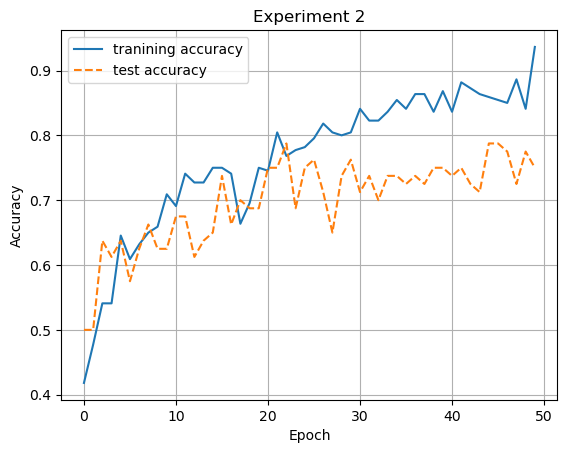

In [50]:
import matplotlib.pyplot as plt
# 繪製精準度
plt.plot(history_2.history['accuracy'], label='tranining accuracy')
plt.plot(history_2.history['val_accuracy'], '--', label='test accuracy')
plt.title('Experiment 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 繪製損失函數圖

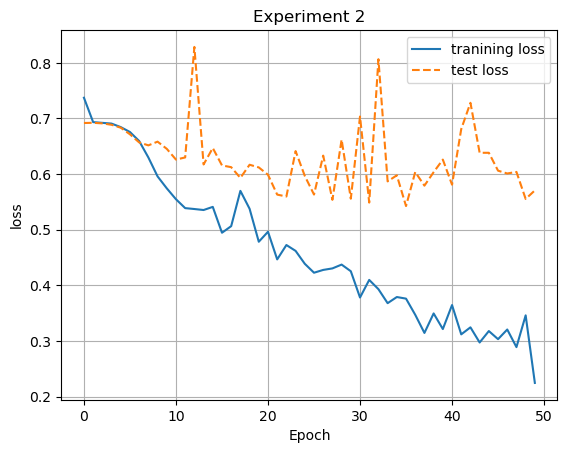

In [48]:
import matplotlib.pyplot as plt
# 繪製損失
plt.plot(history_2.history['loss'], label='tranining loss')
plt.plot(history_2.history['val_loss'], '--', label='test loss')
plt.title('Experiment 2')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()